In [56]:

# CUDA_LAUNCH_BLOCKING=1
import torch
import torch.nn as nn
import numpy as np 

import random

import tqdm
import matplotlib.pyplot as plt

In [57]:
device = torch.device("cuda:5")

H = torch.load("test/original_weights.pt")["H"].to(device).float()
weights = torch.load("test/original_weights.pt")["weights"].to(device).float()    

In [58]:
import sklearn.cluster as cluster

In [68]:
import torch.jit as jit

# @jit.script
def cluster_e_step(X:torch.Tensor,centriods:torch.Tensor,
                   weights:torch.Tensor,
                     subblock_size:int = 1024, 
                        stochastic_rounding:bool = False,
                        round_between_top_n:int = 2):
    
    """
    X: torch tensor of the weights, rearanged into a shape of (n, d)
    centriods: torch.tensor of the centriods, shape of (k, d)
    weights: torch.tensor of shape (n,d)
    """

    n = X.shape[0]
    assignments = torch.zeros(n, dtype = torch.int64, device = X.device)
    
    for i in range(0, n, subblock_size):
        X_block = X[i:i+subblock_size]
        weights_block = weights[i:i+subblock_size]
        errors = (X_block.unsqueeze(-1) - centriods.T.unsqueeze(0))**2
        #shape of (n, d, k)

        #multiply by the diagonal
        errors = errors * weights_block.unsqueeze(-1)

        #sum by the d
        errors = errors.sum(1)
        #shape of (n, k)
        # print(errors[0,10,:])
        if stochastic_rounding:
            errors_top, errors_indices = errors.topk(round_between_top_n, dim = -1, largest = False)

            probabilites = errors_top.max(-1, keepdim = True)[0] - errors_top + 1e-6

            chosen_indices = torch.multinomial(probabilites, 1)
            
            assignments_block = errors_indices[torch.arange(errors_indices.shape[0]), chosen_indices.squeeze(-1)]
            # print(assignments_block[0],errors.argmin(-1)[0])
            n_changes = torch.sum(assignments_block != errors.argmin(-1)).item()
            # if n_changes > 0:
            #     print("n_changes:", n_changes)
            # raise ValueError

        else: 
            assignments_block = errors.argmin(-1)
        # print(assignments_block[0,10])
        assignments[i:i+subblock_size] = assignments_block
    return assignments

@jit.script
def cluster_m_step(X:torch.Tensor, assignments:torch.Tensor, k:int, weights:torch.Tensor):
    """
    X: torch tensor of the weights, rearanged into a shape of (n, d)
    assignments: torch.tensor of the assignments, shape of (n)
    k: int, number of clusters
    weights: torch.tensor of shape (n, d)
    """
    n, d = weights.shape

    #compute the new centriods
    centriods = torch.zeros((k,d), dtype = weights.dtype, device = weights.device)
    #shape of (k,d)
    for i in range(k):
        assignment_X = X[assignments == i] #shape of (n_i,d)
        assignments_weights = weights[assignments == i] #shape of (n_i,d)

        centriods[i] = torch.sum(assignments_weights * assignment_X, dim = 0) / torch.sum(assignments_weights, dim = 0)

    return centriods

# @jit.script
def our_cluster(X:torch.Tensor, k:int, weights:torch.Tensor, n_iter:int = 100,
                stochastic_rounding: bool|str = False,
                round_between_top_n:int = 2):
    """
    weights: torch tensor of the weights, rearanged into a shape of (n, d)
    k: int, number of clusters
    weights: torch.tensor of shape (n, d)
    n_iter: int, number of iterations

    """
    n, d = weights.shape


    n_1 = torch.from_numpy(np.random.choice(n, k, replace = False)).to(device)
    centriods = X[n_1, :]
        # print(centriods)
    #shape of (k, d)
    for i in tqdm.tqdm(range(n_iter)):
        # print("X.shape = ", X.shape, "centriods.shape = ", centriods.shape, "weights.shape = ", weights.shape)
        assignments = cluster_e_step(X, centriods, weights, stochastic_rounding = stochastic_rounding == "all", round_between_top_n = round_between_top_n)
        # print(assignments)
        # print(assignments.shape)
        centriods = cluster_m_step(X, assignments, k, weights)
        if i > 0:
            if torch.all(assignments == assignments_old):
                # print("breaking at iteration", i)
                break
            # print("n_change:", torch.sum(assignments != assignments_old))
        assignments_old = assignments.clone()
    
    assignments = cluster_e_step(X, centriods, weights, stochastic_rounding = stochastic_rounding != False, round_between_top_n = round_between_top_n)
    return assignments, centriods
    

def reconstruct_cluster(assignments, centriods):
    """
    assignments: torch.tensor of the assignments, shape of (n, m/d)
    centriods: torch.tensor of the centriods, shape of (k, d)
    H_diag: torch.tensor of shape (m/d,d)
    """
    reconstructed_X = centriods[assignments,:]
    #shape of (n, m/d, d)
    return reconstructed_X


In [69]:
a = torch.tensor([[1,2],[3,4]]).float()

torch.norm(a, dim = 1)

tensor([2.2361, 5.0000])

In [84]:
torch.random.manual_seed(0)
np.random.seed(0)
torch.cuda.manual_seed(0)
random.seed(0)
def create_mask(data,percent_top):
    """
    data: torch.tensor of shape (n)
    percent_top: float, the percentage of the top values to keep
    """

    threshold = torch.quantile(data, 1-percent_top/100)
    return data < threshold


d = 4
percent_dense_rowise = 0.5
percent_dense_columnwise = 1


row_mask = create_mask(torch.norm(weights, dim = 1), percent_dense_rowise)
column_mask = create_mask(torch.norm(weights, dim = 0), percent_dense_columnwise) & create_mask(torch.norm(H, dim = 0), percent_dense_columnwise)

print("row_mask.sum() = ", row_mask.sum())
print("column_mask.sum() = ", column_mask.sum())


def mask_round(mask, d, round_up = False):

    indexs = torch.arange(mask.shape[0], device = mask.device)
    if round_up:
        indexs = indexs[~mask]
    else:
        indexs = indexs[mask]

    indexs = indexs[torch.randperm(indexs.shape[0])]
    i = 0
    while mask.sum() % d != 0:
        
        mask[indexs[i]] = ~mask[indexs[i]]
        i += 1

    return mask

if percent_dense_columnwise == 0:
    column_mask = torch.ones(weights.shape[1], dtype = torch.bool, device = weights.device)
else:
    column_mask = mask_round(column_mask, d)
    
if percent_dense_rowise == 0:
    row_mask = torch.ones(weights.shape[0], dtype = torch.bool, device = weights.device)    
else:
    row_mask = mask_round(row_mask, d)


mask = row_mask.unsqueeze(1) & column_mask.unsqueeze(0)

print("row_mask.sum() = ", row_mask.sum())
print("column_mask.sum() = ", column_mask.sum())


row_mask.sum() =  tensor(4075, device='cuda:5')
column_mask.sum() =  tensor(4052, device='cuda:5')
row_mask.sum() =  tensor(4072, device='cuda:5')
column_mask.sum() =  tensor(4052, device='cuda:5')


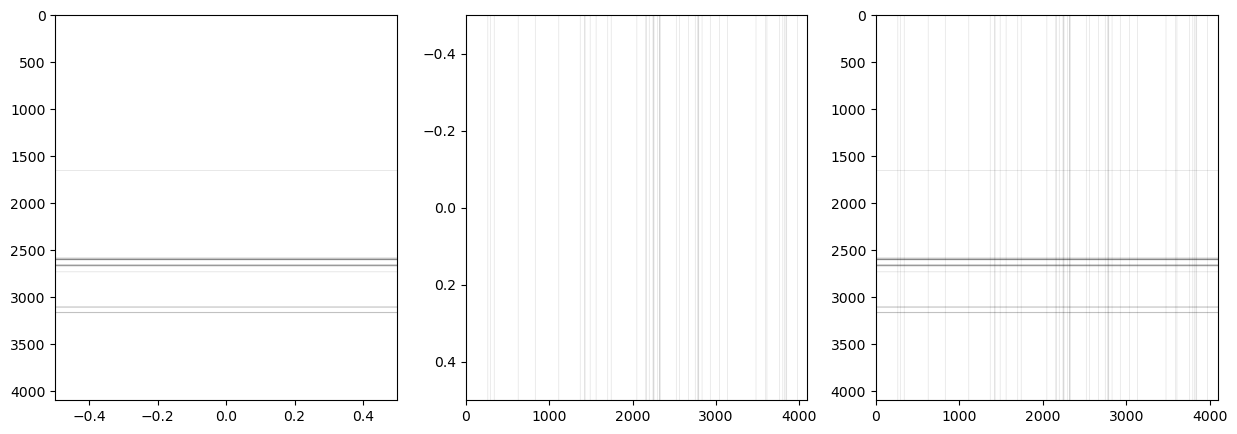

In [71]:
cmap = "gray"
fig,axs = plt.subplots(1,3, figsize = (15,5))

plt.sca(axs[0])
plt.imshow(row_mask.unsqueeze(1).cpu().numpy(), cmap = cmap, aspect = "auto")
plt.sca(axs[1])
plt.imshow(column_mask.unsqueeze(0).cpu().numpy(), cmap = cmap, aspect = "auto")
plt.sca(axs[2])
plt.imshow(mask.cpu().numpy(), cmap = cmap, aspect = "auto")

In [72]:
torch.mean(torch.tensor([[1,2],[3,4]]).float(), dim = 1)

tensor([1.5000, 3.5000])

In [73]:
x = (weights/torch.norm(weights, dim = 1, keepdim = True))
x = x/ torch.norm(x, dim = 0, keepdim = True)
print(f"x min = {x.min()}, x max = {x.max()}, x mean = {x.mean()}, x std = {x.std()}")
#  torch.mean(torch.abs(weights), dim = 1)).max()

x min = -0.09596569836139679, x max = 0.10361956059932709, x mean = 1.0979965736623853e-07, x std = 0.015625


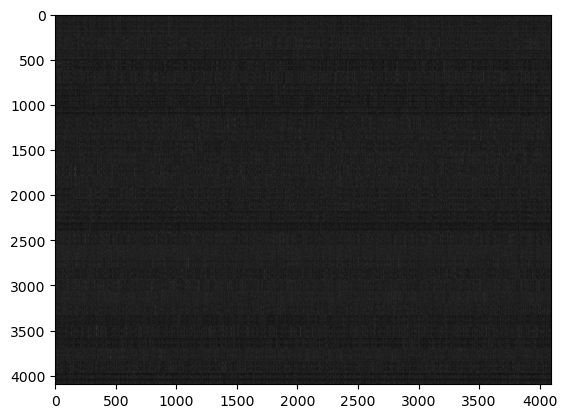

In [74]:
plt.imshow(torch.abs(x).cpu().numpy(), cmap = "gray", aspect = "auto")

In [78]:
torch.random.manual_seed(0)
np.random.seed(0)
torch.cuda.manual_seed(0)
random.seed(0)
import tqdm
import sklearn.cluster

n_iters = 25
d = 4
n_bits = 2
k_coseine_codebook = 2**(d*n_bits)
keep_top = 0.01

# print("average bits:", (np.log2(k_magnitude_codebook) + np.log2(k_coseine_codebook))/d)

weights_norms_rowwise = torch.norm(weights, dim = 0)
weights_normalized = weights / weights_norms_rowwise.unsqueeze(0)
weights_norms_columnwise = torch.norm(weights_normalized, dim = 1)
weights_normalized = weights_normalized / weights_norms_columnwise.unsqueeze(1)

denormalize_matrix = weights_norms_rowwise.unsqueeze(0) * weights_norms_columnwise.unsqueeze(1)
print("denormalize_matrix.shape = ", denormalize_matrix.shape)
overhead = k_coseine_codebook * 16 * d

encoding_bits = (np.ceil(np.log2(k_coseine_codebook)))/d * weights.numel()

sparse_bits = 16 * torch.sum(~mask).item()

normalization_overhead = 16 * (weights_norms_columnwise.numel() + weights_norms_rowwise.numel())


print("sparse bits:", sparse_bits/weights.numel(),
      
       "encoding bits:",encoding_bits/weights.numel(),
        "overhead:", overhead/weights.numel(),
        "normalization overhead:", normalization_overhead/weights.numel())
print("bits per value:", (sparse_bits + encoding_bits + overhead + normalization_overhead)/weights.numel())
# raise ValueError


print("weights_masked.shape = ", weights_normalized.shape)
subvector_assignments = torch.arange(weights_normalized.shape[1]).reshape((-1, d))


# assert torch.isfinite(weights_masked).all()
# assert torch.isfinite(H).all()

weights_reshaped = weights_normalized[:,subvector_assignments] 
print("weights_reshaped.shape = ", weights_reshaped.shape)
#shape of (n, m/d, d)

print(H[column_mask,column_mask].shape)
H_diag = torch.diag(H)[subvector_assignments]
# print("H_diag.shape = ", H_diag.shape)
# H_diag = torch.ones(subvector_assignments.shape, device = H.device)
#shape of (n, m/d, d)

# raise ValueError
# print(torch.quantile(weights_norms, 1-keep_top), torch.max(weights_norms), torch.min(weights_norms))
# print(torch.sum(mask)/(mask.shape[0]*mask.shape[1]), 1 - torch.sum(mask)/(mask.shape[0]*mask.shape[1]))
# raise ValueError
#mask of the top 1% of the weights


print("weights_norms_masked.shape", weights_reshaped.shape)
print(denormalize_matrix[:,subvector_assignments].shape)
print(H_diag.unsqueeze(0).expand(weights_reshaped.shape[0], -1, -1).shape)

mappings, codebooks = our_cluster(weights_reshaped.reshape(-1,d), k_coseine_codebook, (H_diag.unsqueeze(0).expand(weights_reshaped.shape[0], -1, -1)
                                                                                       * denormalize_matrix[:,subvector_assignments]
                                                                                       ).reshape(-1,d), n_iter = n_iters,
                                                                                           stochastic_rounding = "all",
                                                                                             round_between_top_n = 2)
                                                                                           
#mapping of shape (m/d*n)
#codebooks of shape (k, d)

weights_quantized = torch.empty_like(weights)
weights_quantized[:,subvector_assignments] = codebooks[mappings,:].reshape(weights_quantized.shape[0], -1, d)

weights_quantized *= denormalize_matrix

weights_quantized[~mask] = weights[~mask]


diff = weights - weights_quantized

average_error = torch.sum(torch.abs(diff)**1)/torch.sum(torch.abs(weights)**1)

H_error = torch.einsum('ik,kl,il->', diff, H/H.shape[0], diff)

free, total = torch.cuda.mem_get_info(device)
print(f"free = {free/1024/1024}, total = {total/1024/1024}")

print(f"average error {average_error}, H error {H_error}")

denormalize_matrix.shape =  torch.Size([4096, 4096])
sparse bits: 0.264617919921875 encoding bits: 2.0 overhead: 0.0009765625 normalization overhead: 0.0078125
bits per value: 2.273406982421875
weights_masked.shape =  torch.Size([4096, 4096])
weights_reshaped.shape =  torch.Size([4096, 1024, 4])
torch.Size([4052])
weights_norms_masked.shape torch.Size([4096, 1024, 4])
torch.Size([4096, 1024, 4])
torch.Size([4096, 1024, 4])


100%|██████████| 25/25 [00:43<00:00,  1.73s/it]


free = 45604.0625, total = 48676.75
average error 0.3348257541656494, H error 1.982857346534729


In [80]:

codebooks_use = codebooks.clone().requires_grad_(True)


n_iters = 1000
lr = 1e-3
clamp_gradients = 1e-1
prev_loss = 1e10
patience = 10
eps = 1e-4

for i in range(n_iters):
    weights_quantized = torch.empty_like(weights)
    weights_quantized[:,subvector_assignments] = codebooks_use[mappings,:].reshape(weights_quantized.shape[0], -1, d)

    weights_quantized *= denormalize_matrix

    weights_quantized[~mask] = weights[~mask]

    diff = weights - weights_quantized
    average_error = torch.sum(torch.abs(diff)**1)/torch.sum(torch.abs(weights)**1)

    H_error = torch.einsum('ik,kl,il->', diff, H/H.shape[0], diff)
    print(f"average error {average_error}, H error {H_error}")
    H_error.backward()

    if H_error >= prev_loss:
        lr = lr/2
        print("reducing lr to ", lr)
        
    if prev_loss - H_error < eps:
        patience -= 1
        if patience == 0:
            print("stopped after", i, "iterations")
            break
    else:
        patience = 10
    prev_loss = H_error.item()
    with torch.no_grad():

        codebooks_use.grad = torch.clamp(codebooks_use.grad, -clamp_gradients, clamp_gradients)
        codebooks_use -= lr * codebooks_use.grad
        codebooks_use.grad.zero_()

average error 0.3348257541656494, H error 1.982857346534729
average error 0.3349812626838684, H error 1.8965067863464355
average error 0.33525779843330383, H error 1.8164334297180176
average error 0.335649698972702, H error 1.7426159381866455
average error 0.33614784479141235, H error 1.6750189065933228
average error 0.3367452323436737, H error 1.613577127456665
average error 0.3374330699443817, H error 1.5582163333892822
average error 0.3382008969783783, H error 1.508847713470459
average error 0.3390340805053711, H error 1.46535325050354
average error 0.3399120569229126, H error 1.4275850057601929
average error 0.3408088684082031, H error 1.3953025341033936
average error 0.3416966497898102, H error 1.3681877851486206
average error 0.3425484001636505, H error 1.3458536863327026
average error 0.3433268666267395, H error 1.3278076648712158
average error 0.3440123200416565, H error 1.313442587852478
average error 0.3445720076560974, H error 1.3021774291992188
average error 0.3449702560901

In [24]:
codebooks_use2 = codebooks_use.detach()

weights_reconstructed = torch.empty_like(weights_masked)
weights_reconstructed[:,subvector_assignments] = codebooks_use[mappings,:].reshape(weights_reconstructed.shape[0], -1, d)

weights_reshaped = weights_masked[:,subvector_assignments]


errors = torch.norm(weights_reconstructed - weights_reshaped, dim = -1)
#shape of (n, m/d)



weights_quantized = torch.empty_like(weights)

weights_quantized[mask] = weights_reconstructed.flatten()
weights_quantized[~mask] = weights[~mask]


diff = weights - weights_quantized

average_error = torch.sum(torch.abs(diff)**1)/torch.sum(torch.abs(weights)**1)

H_error = torch.einsum('ik,kl,il->', diff, H/H.shape[0], diff)

print(f"average error {average_error}, H error {H_error}")


NameError: name 'weights_masked' is not defined

(array([ 5., 10., 10., 15., 13., 15., 12., 12., 15.,  6., 14.,  7.,  7.,
         8., 10.,  7.,  3.,  5.,  3.,  8.,  5.,  3.,  4.,  2.,  2.,  1.,
         7.,  4.,  0.,  3.,  2.,  0.,  3.,  1.,  1.,  2.,  1.,  4.,  1.,
         1.,  1.,  0.,  1.,  0.,  1.,  3.,  0.,  0.,  0.,  1.,  1.,  3.,
         0.,  1.,  0.,  0.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,
         1.,  2.,  0.,  0.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,
         0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([0.00136226, 0.00411849, 0.00687472, 0.00963095, 0.01238718,
        0.01514341, 0.01789964, 0.02065586, 0.02341209, 0.02616832,
        0.02892455, 0.03168078, 0.03443701, 0.03719324, 0.03994947,
        0.0427057 , 0.04546193, 0.04821816, 0.05097438, 0.05373061,
        0.05648684, 0.05924307, 0.0619993 , 0.06475553, 0.06751176,
        0.07026799, 0.07302422, 0.07578044, 0.07853667, 0.0812929 ,
        0.08404914, 0.0868

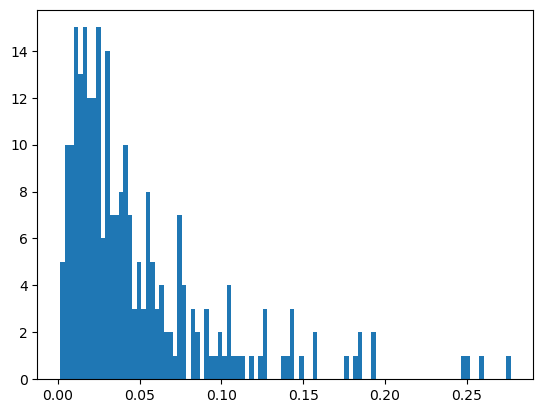

In [10]:
plt.hist(torch.norm(codebooks_use, dim = 1).detach().cpu(), bins = 100)

In [15]:
# import pca
import sklearn.decomposition

pca = sklearn.decomposition.PCA(n_components = 2)

#perform a pca on the weights
weights_pca = pca.fit_transform(weights_use.cpu().numpy())

#transform the old codebooks and the new codebooks
codebooks_pca = pca.transform(codebooks_use.cpu().detach().numpy())
codebooks_old_pca = pca.transform(codebooks.cpu().numpy())

outliers_pca = pca.transform(weights_reshaped[~mask_norm,:].cpu().numpy())
H_large_pca = pca.transform(weights_reshaped[~mask_H,:].cpu().numpy())

#plot out countour plot of the weights
import matplotlib.pyplot as plt
import seaborn as sns


KeyboardInterrupt: 

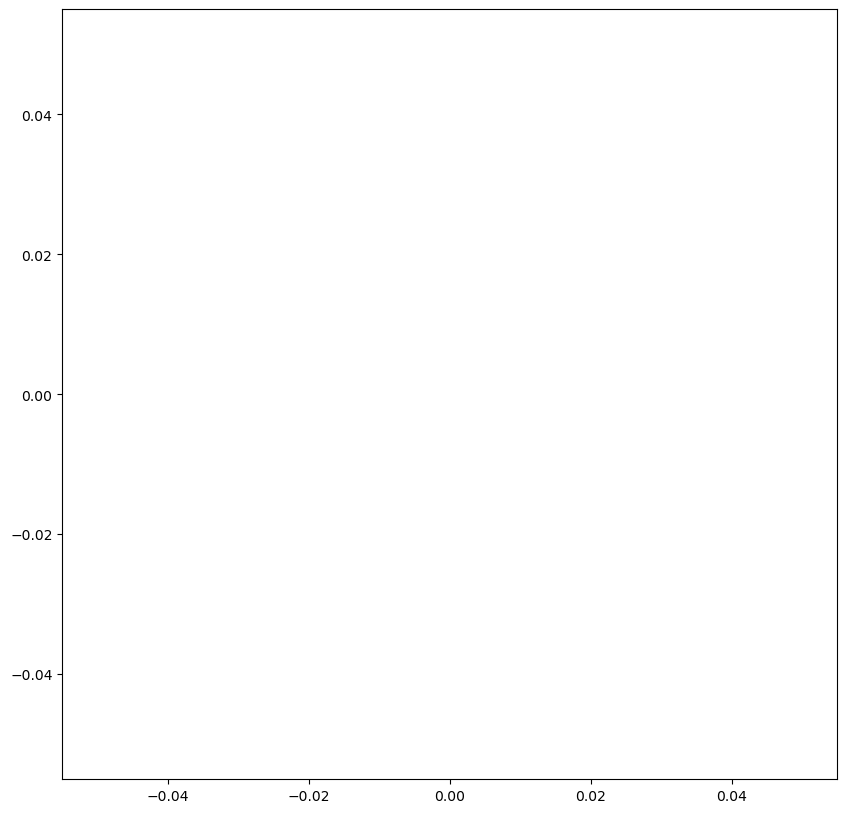

In [17]:
#plot out countour plot of the weights
import matplotlib.pyplot as plt
import seaborn as sns

n_plot = 40000
indicies = np.random.choice(weights_pca.shape[0], n_plot, replace = False)

plt.figure(figsize=(10,10))
sns.kdeplot(x=weights_pca[indicies,0], y=weights_pca[indicies,1], fill = True)

plt.scatter(codebooks_pca[:,0], codebooks_pca[:,1], c = 'r', label = "new codebooks", s = 10)
plt.scatter(codebooks_old_pca[:,0], codebooks_old_pca[:,1], c = 'g', label = "old codebooks",
            s = 10)

#draw arrrows between the old and new codebooks
for i in range(codebooks_pca.shape[0]):
    plt.arrow(codebooks_old_pca[i,0], codebooks_old_pca[i,1], codebooks_pca[i,0] - codebooks_old_pca[i,0],
              codebooks_pca[i,1] - codebooks_old_pca[i,1], head_width=0.005, head_length=0.005, fc='k', ec='k')

# plt.scatter(outliers_pca[:,0], outliers_pca[:,1], c = 'y', label = "outliers", s = 1, alpha = 0.5)
# plt.scatter(H_large_pca[:,0], H_large_pca[:,1], c = 'b', label = "H large", s = 1, alpha = 0.5)
plt.legend()
plt.title("Weights distribution")

In [11]:


soft_one_hot_value = 5
# for i in range(k_magnitude_codebook):
    # if codebooks[i].shape[0] < k_coseine_codebook:
    #     continue
codebooks_use = codebooks.clone().requires_grad_(True)



mappings_use_ = torch.zeros((k_coseine_codebook, mappings.shape[0]), dtype = codebooks_use.dtype, device = codebooks.device)
# print(assignments_dict[i].shape)
mappings_use_[mappings, torch.arange(mappings.shape[0])] = soft_one_hot_value

mappings_use_ = mappings_use_.clone().requires_grad_(True)
# raise ValueError
# magnitude_codebook_use = magnitude_codebook[:,0].clone()
n_iters = 100
lr = 1e-3
lr_map = 1e-3
clamp_gradients = 1e-1
prev_loss = 1e10

lambda_ = 0.1
betas = np.linspace(8,1, n_iters)

losses = []
 
for iters in range(n_iters):
    beta = betas[iters]

    weights_reconstructued_flat =  torch.zeros_like(weights_reshaped)

    weights_reconstructued_flat[~mask,:] = weights_reshaped[~mask]
    # print(codebooks_use[0])

    regularization_loss = 0 

    assignments_ = torch.softmax(mappings_use_, dim = 0)
    # raise ValueError
    # print(assignments_.shape)
    # print(codebooks_use[i].shape)
    # weights_reconstructued_flat[mask_,:] = codebooks_use[i][assignments_dict[i],:]
    regularization_loss = torch.sum(1 - torch.abs(2*assignments_ - 1)**beta)
    # weights_reconstructued_flat[mask_,:] = torch.clip(codebooks_use[i][assignments_dict[i],:],-1,1) * torch.exp(magnitude_codebook_use[i])
    weights_reconstructued_flat[mask,:] = assignments_.T @ codebooks_use



    weights_reconstructued = torch.empty_like(weights)

    weights_reconstructued[:,row_assignments] = weights_reconstructued_flat.reshape(weights_reconstructued.shape[0], -1, d)
    # print(weights_reconstructued)

    diff = weights - weights_reconstructued
    average_error = torch.sum(torch.abs(diff)**1)/torch.sum(torch.abs(weights)**1)


    H_error = torch.einsum('ik,kl,il->', diff, H/H.shape[0], diff)

    loss = H_error + lambda_ * regularization_loss
    print(f"average error {average_error}, H error {H_error}, regularization_loss = {regularization_loss}")
    loss.backward()
    losses.append(H_error.item())
    if H_error > prev_loss:
        lr = lr * 0.9
        print("reducing lr to ", lr)
    prev_loss = H_error.item()
    with torch.no_grad():
        # codebooks_use.grad = torch.clamp(codebooks_use.grad, -clamp_gradients, clamp_gradients)
        # codebooks_use -= lr * codebooks_use.grad
        # codebooks_use.grad.zero_()
        # print(mappings_use_.grad)
        mappings_use_.grad = torch.clamp(mappings_use_.grad, -clamp_gradients, clamp_gradients)
        mappings_use_ -= lr_map * mappings_use_.grad
        mappings_use_.grad.zero_()
        codebooks_use.grad.zero_()
        # magnitude_codebook_use -= torch.clip(lr * magnitude_codebook_lr_mult * magnitude_codebook_use.grad, -clamp_gradients*magnitude_codebook_lr_mult, clamp_gradients*magnitude_codebook_lr_mult)
        # magnitude_codebook_use.grad = None



average error 0.45272842049598694, H error 8.723808288574219, regularization_loss = 18361468.0
average error 0.45272859930992126, H error 8.72304916381836, regularization_loss = 18237976.0
average error 0.4527287185192108, H error 8.72229290008545, regularization_loss = 18114116.0
average error 0.45272889733314514, H error 8.721476554870605, regularization_loss = 17989760.0
average error 0.45272907614707947, H error 8.72071647644043, regularization_loss = 17865062.0
average error 0.4527292549610138, H error 8.719961166381836, regularization_loss = 17739884.0
average error 0.4527294337749481, H error 8.719202995300293, regularization_loss = 17614298.0
average error 0.45272961258888245, H error 8.718391418457031, regularization_loss = 17488246.0
average error 0.452729731798172, H error 8.717632293701172, regularization_loss = 17361786.0
average error 0.4527299106121063, H error 8.716875076293945, regularization_loss = 17234872.0
average error 0.45273008942604065, H error 8.71611976623535

In [12]:
assignments_[:,0]

tensor([0.0061, 0.0061, 0.0061, 0.0061, 0.0061, 0.9090, 0.0061, 0.0061, 0.0061,
        0.0061, 0.0061, 0.0061, 0.0061, 0.0061, 0.0061, 0.0061],
       device='cuda:6', grad_fn=<SelectBackward0>)

In [56]:
assignments_new = {i: assignments_use[i].argmax(0) for i in assignments_use}

weights_reconstructued_flat =  torch.zeros_like(weights_reshaped)

weights_reconstructued_flat[~mask,:] = weights_reshaped[~mask]
# print(codebooks_use[0])

with torch.no_grad():

    regularization_loss = 0
    for i in range(k_magnitude_codebook):
        mask_i = magnitude_assignments == i
        assert torch.any(mask_i)
        mask_ = torch.zeros_like(mask)
        mask_[mask] = mask_i
        if i not in codebooks_use:
            weights_reconstructued_flat[mask_,:] = codebooks[i][assignments_dict[i],:] * torch.exp(magnitude_codebook_use[i])
            continue    

        weights_reconstructued_flat[mask_,:] = torch.clip(codebooks_use[i][assignments_new[i],:],-1,1) * torch.exp(magnitude_codebook_use[i])
    # weights_reconstructued_flat[mask,:] = centriods[assignments,:] * torch.from_numpy(np.exp(magnitude_codebook[:,0][magnitude_assignments])).reshape(-1,1).float()


    weights_reconstructued = torch.empty_like(weights)

    weights_reconstructued[:,row_assignments] = weights_reconstructued_flat.reshape(weights_reconstructued.shape[0], -1, d)
    # print(weights_reconstructued)

    diff = weights - weights_reconstructued
    average_error = torch.sum(torch.abs(diff)**1)/torch.sum(torch.abs(weights)**1)


H_error = torch.einsum('ik,kl,il->', diff, H/H.shape[0], diff)

loss = H_error + lambda_ * regularization_loss
print(f"average error {average_error}, H error {H_error}")

average error 0.5536376237869263, H error 5.610358715057373


In [57]:
n_change = 0
for i in codebooks_use:

    n_change += torch.sum(assignments_new[i] != assignments_dict[i])

print("n_change = ", n_change)

n_change =  tensor(0, device='cuda:6')


In [58]:
assignments_dict[0]

tensor([15, 11,  1,  ...,  2,  8,  9], device='cuda:6')

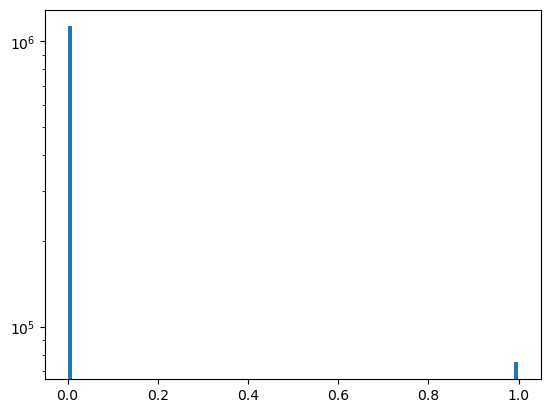

In [59]:
plt.hist(assignments_.detach().cpu().numpy().flatten(), bins = 100)
plt.yscale('log')

In [61]:
assignments_use[0][assignments_dict[0],:].detach().cpu().numpy()

array([[ 9.9999952e+00,  1.2635506e-07,  1.5326428e-07, ...,
        -5.7824224e-08, -1.2287417e-07, -4.6445859e-08],
       [ 1.1943567e-07,  9.9999952e+00,  9.9999924e+00, ...,
        -5.9382781e-08,  1.0000002e+01, -4.4714639e-08],
       [ 1.1943567e-07,  9.9999952e+00,  9.9999924e+00, ...,
        -5.9382781e-08,  1.0000002e+01, -4.4714639e-08],
       ...,
       [ 5.5878967e-08,  6.5669362e-08,  7.8594709e-08, ...,
         1.0000001e+01, -6.2216365e-08, -4.7712575e-08],
       [ 1.1943567e-07,  9.9999952e+00,  9.9999924e+00, ...,
        -5.9382781e-08,  1.0000002e+01, -4.4714639e-08],
       [ 5.4991109e-08,  6.7893268e-08,  8.2246736e-08, ...,
        -6.4254273e-08, -6.5741027e-08,  1.0000002e+01]], dtype=float32)

In [62]:
codebooks[i][assignments_dict[i],:]

tensor([[ 4.3442e-02, -4.5606e-02,  7.5983e-02,  ...,  1.2069e-02,
          7.2188e-02,  1.0297e-04],
        [ 4.3442e-02, -4.5606e-02,  7.5983e-02,  ...,  1.2069e-02,
          7.2188e-02,  1.0297e-04],
        [ 4.3442e-02, -4.5606e-02,  7.5983e-02,  ...,  1.2069e-02,
          7.2188e-02,  1.0297e-04],
        ...,
        [-1.5629e-01,  1.7860e-01, -4.9690e-02,  ..., -1.5907e-01,
          2.4043e-02,  4.6148e-02],
        [-1.3026e-01,  3.9753e-02, -6.5690e-02,  ..., -5.2088e-02,
         -3.5687e-01,  9.4983e-02],
        [ 2.4803e-02, -3.7862e-01,  2.0537e-01,  ..., -2.6397e-02,
         -9.8013e-02, -3.7012e-02]], device='cuda:6')

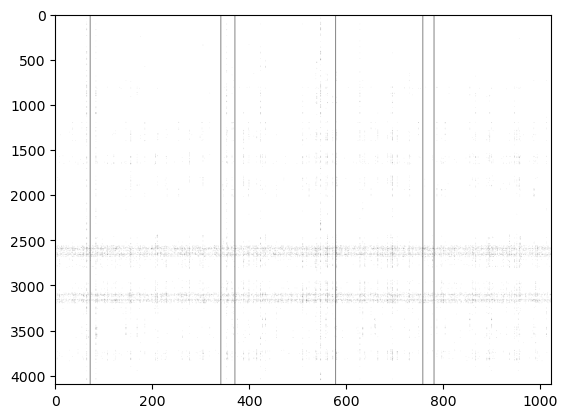

In [18]:
plt.imshow(mask.cpu().numpy(),aspect = 'auto', cmap = 'gray')

Text(0.5, 1.0, 'Hessian Mask')

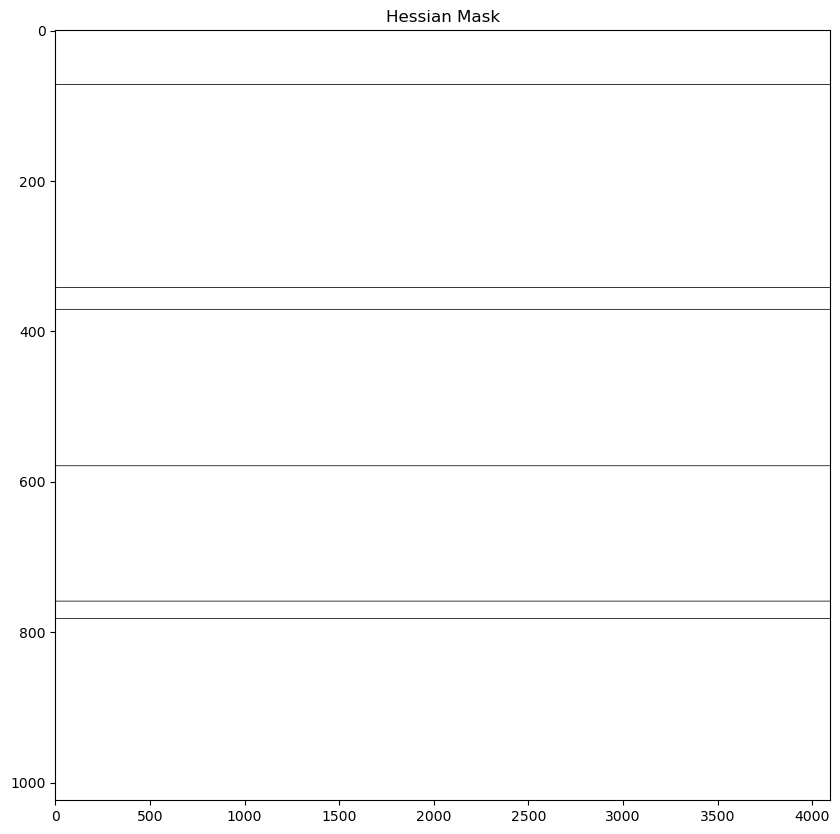

In [24]:
plt.figure(figsize = (10,10))
plt.imshow(mask_H.T.cpu().numpy(),aspect = 'auto', cmap = 'gray')
plt.title("Hessian Mask")

Text(0.5, 1.0, 'Norm Mask')

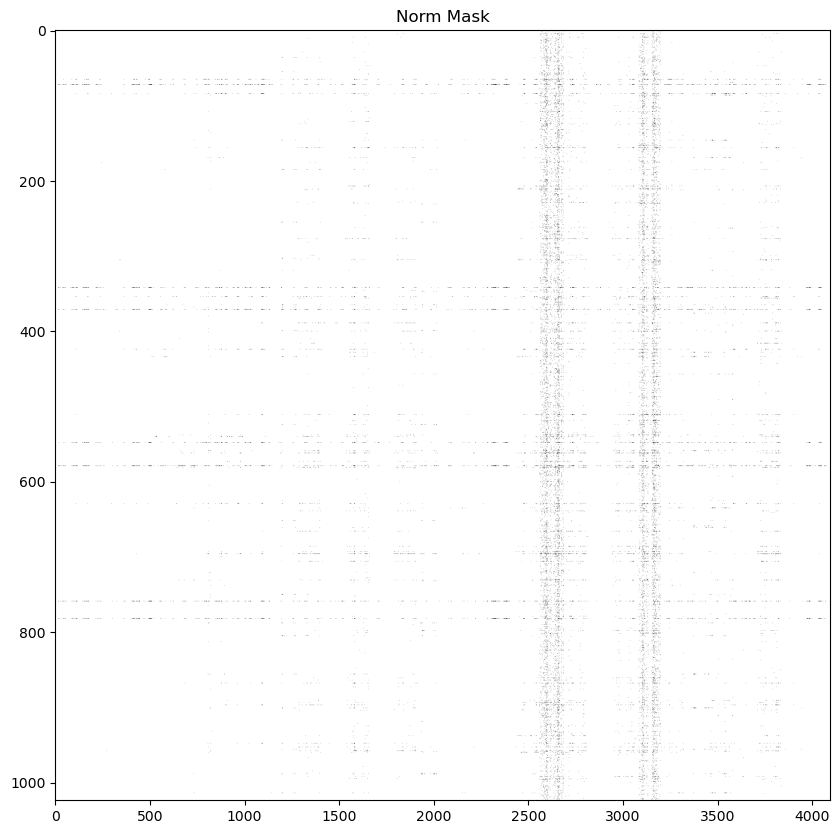

In [25]:
plt.figure(figsize=(10,10))
plt.imshow(mask_norm.T.cpu().numpy(),aspect = 'auto', cmap = 'gray')
plt.title("Norm Mask")

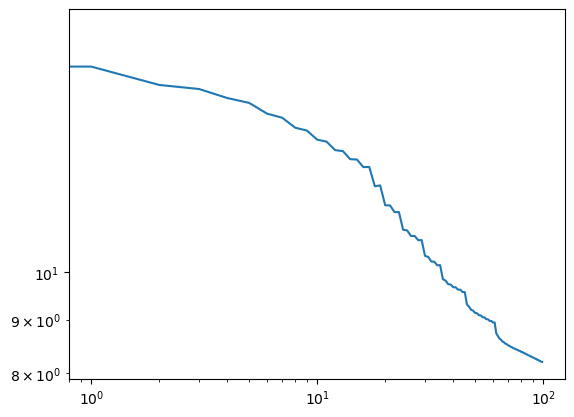

In [15]:
import matplotlib.pyplot as plt

plt.plot(losses)
plt.yscale("log")
plt.xscale("log")